In [1]:
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import quandl
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta
import time
import fix_yahoo_finance as yf
from scipy.optimize import minimize
import datetime
import sqlite3
from sqlalchemy import create_engine
import os

C:\Users\SIMON.BLACK\AppData\Local\Continuum\anaconda3\lib\site-packages\fix_yahoo_finance\__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



In [2]:
ticker_yahoo = pd.read_excel('C:\\Users\\SIMON.BLACK\\Documents\\GitHub\\MF_1_Sem\\nasdaq100.xlsx', 
                       sheet_name = 'Ticker')     

ticker_yahoo = list(ticker_yahoo['Symbol'])


In [3]:
#Yahoo as data provider
end_date =  date.today() 
start_date = end_date - datetime.timedelta(days=2*365)

In [4]:
def yahoo_stock_as_column(stocks, end_date, start_date):
    start_time = time.clock()
    df_folio = pd.DataFrame(yf.download(stocks[0], 
                      start = start_date, 
                      end = end_date, 
                      progress=False)['Adj Close'])
    df_folio.columns = [stocks[0]]#set stock TICKER
    


    for i in stocks[1:]:
        price = pd.DataFrame(yf.download(i, 
                          start = start_date, 
                          end = end_date, 
                          progress=False)['Adj Close'])
    
        df_folio[i] = price
        print('Completed:', i)
    print('Stocks Downloaded:', df_folio.shape[1])
    print(time.clock() - start_time, "seconds for data download after module import")
    return df_folio

In [5]:
def log_returns(data):
    
	log_returns = np.log(data/data.shift(1))
	return log_returns
    
x = log_returns(yahoo_stock_as_column(ticker_yahoo, end_date, start_date))

C:\Users\SIMON.BLACK\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Completed: AAPL
Completed: AMZN
Completed: FB
Completed: GOOG
Completed: GOOGL
Completed: INTC
Completed: PEP
Completed: NFLX
Completed: CSCO
Completed: NVDA
Completed: CMCSA
Completed: ADBE
Completed: AMGN
Completed: TSLA
Completed: PYPL
Completed: COST
Completed: CHTR
Completed: TXN
Completed: AVGO
Completed: GILD
Completed: SBUX
Completed: QCOM
Completed: TMUS
Completed: MDLZ
Completed: INTU
Completed: VRTX
Completed: FISV
Completed: AMD
Completed: ADP
Completed: ISRG
Completed: REGN
Completed: BKNG
Completed: BIIB
Completed: CSX
Completed: ATVI
Completed: MU
Completed: AMAT
Completed: ILMN
Completed: JD
Completed: ADSK
Completed: ADI
Completed: WBA
Completed: LRCX
Completed: KHC
Completed: EXC
Completed: XEL
Completed: EA
Completed: ROST
Completed: MNST
Completed: EBAY
Completed: DXCM
Completed: CTSH
Completed: ORLY
Completed: MELI
Completed: LULU
Completed: MAR
Completed: BIDU
Completed: NXPI
Completed: NTES
Completed: KLAC
Completed: SGEN
Completed: VRSN
Completed: VRSK
Completed

C:\Users\SIMON.BLACK\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [8]:
############### Get Treasury Rate ("risk free") ###############
from fredapi import Fred
fred = Fred(api_key='6be21606d68265a883ef83d0fd9b93a4')
symbol = 'DGS1' #risk free (treasury USD) for 1 year maturity analogous to our historic time horizon for stock returns
risk_free_series = fred.get_series(symbol).tail(x.shape[0]).dropna()#One year time series for 1Y USD treasury
rf = np.mean(risk_free_series.tail(250)) / 100#take last months mean and convert to standard form (percentage given) -> 1/100
############### Get Treasury Rate ("risk free") ###############

In [11]:
####Split trian/test phase in half and some data manip
x_full = x

#Write to database as backup (data pull takes for ever)
path = 'C:\\Users\\SIMON.BLACK\\OneDrive - Zurich Insurance\\ZHAW\Hausarbeit\\data'
os.chdir(path)      
conn = sqlite3.connect('log_returns.db')
cur = conn.cursor()
engine = create_engine("sqlite:///log_returns.db")
x_full.to_sql('log_return_nasdaq', engine, if_exists = 'replace')

df = pd.read_sql_query('select * from log_return_nasdaq', conn)

#Remove NaNs and Stocks where there was no data two years ago (new stocks)
counter = 0
for i in ticker_yahoo:
    l = len(df[i].dropna())
    if l == 501:
        counter += 1
        
M = np.zeros((501, counter))
u = 0; tick = []
for i in ticker_yahoo:
    s = np.array(df[i].dropna())
    check = len(s)
    if check == 501: 
        
        M[:,u] = s
        u += 1
        tick.append(i)
M = pd.DataFrame(M); M.columns = tick; date = x_full.reset_index()['Date'][1:x_full.shape[0]]
M = M.set_index(date) 

x_train = M.head(251)
x_test = M.tail(250)


In [13]:
##### Largest Market Cap Nasdaq
path = "C:\\Users\\SIMON.BLACK\\OneDrive - Zurich Insurance\\ZHAW\Hausarbeit\\data\\"
cap = pd.read_excel(path + 'nasdaq_market_cap.xlsx', sheet_name = 'Capitalization')

cap.Cap = cap.Cap.apply(lambda j: float(j.replace(",","")))
cap = cap.sort_values('Cap', ascending = False)
idx = cap.Ticker[0:20]
s = x_train[list(idx)]

#Numerically finding "good" n of stocks interval [10,30]
start_n_stocks = 10
n_stock = np.arange(start_n_stocks, 31)

rep = 0; l = []
for i in n_stock:
    idx = cap.Ticker[0:i]
    s = x_train[list(idx)]
    
    def ret_vol_SR(weights, df = s, riskfree = rf):
        r = sum(df.mean()*weights*252)
        vol = np.sqrt(np.dot(weights.T, np.dot(df.cov()*252, weights)))
        SR = (r - riskfree) / vol
        return np.array([r, vol, SR])

    def negative_SR(weights, df = s, riskfree = rf):
        return -1 * ret_vol_SR(weights, df, riskfree)[2]
    
    def check_weights(weights):
        return np.sum(weights) - 1
    
    initial_guess = np.repeat(1 / s.shape[1], s.shape[1])#equally weighted
       
    con1 = {'type': 'eq', 'fun': check_weights}
    #set minimum weight:
    min_w = 0.01
    con2 = {'type' : 'ineq' , 'fun' : lambda weights: weights - min_w}
    cons = (con1, con2)

    bounds = tuple([(0,1) for i in range(s.shape[1])])

    
    optimal = minimize(negative_SR, initial_guess, method = 'SLSQP', bounds = bounds, constraints = cons)
    w = optimal.x
    y = {'Portfolio': idx, 'Weights': w, 'E(r)_Vol_Sharpe': ret_vol_SR(w, s, rf)}
    l.append(y)
    print("portfolio: ", rep, "n stocks: ", i)
    rep += 1
    
sharpe = np.array([l[k]['E(r)_Vol_Sharpe'][2] for k in range(len(l))])#Extract sharpe rations from different dictionaries in list
print('Best Sharpe Ratio: ', sharpe[sharpe.argmax()], "Portfolio # ", sharpe.argmax())
l[sharpe.argmax()]  
print('# Stocks: ', len(l[sharpe.argmax()]['Weights']))    



portfolio:  0 n stocks:  10
portfolio:  1 n stocks:  11
portfolio:  2 n stocks:  12
portfolio:  3 n stocks:  13
portfolio:  4 n stocks:  14
portfolio:  5 n stocks:  15
portfolio:  6 n stocks:  16
portfolio:  7 n stocks:  17
portfolio:  8 n stocks:  18
portfolio:  9 n stocks:  19
portfolio:  10 n stocks:  20
portfolio:  11 n stocks:  21
portfolio:  12 n stocks:  22
portfolio:  13 n stocks:  23
portfolio:  14 n stocks:  24
portfolio:  15 n stocks:  25
portfolio:  16 n stocks:  26
portfolio:  17 n stocks:  27
portfolio:  18 n stocks:  28
portfolio:  19 n stocks:  29
portfolio:  20 n stocks:  30
Best Sharpe Ratio:  1.6109108283990976 Portfolio #  14
# Stocks:  24


In [18]:
l[sharpe.argmax()]  

{'Portfolio': 64     MSFT
 11     AAPL
 7      AMZN
 6     GOOGL
 5      GOOG
 41       FB
 50     INTC
 70     NVDA
 27     CSCO
 1      ADBE
 69     NFLX
 76      PEP
 75     PYPL
 30    CMCSA
 88     TSLA
 13     ASML
 33     COST
 8      AMGN
 86     TMUS
 20     AVGO
 24     CHTR
 89      TXN
 46     GILD
 84     SBUX
 Name: Ticker, dtype: object,
 'Weights': array([0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.38448526, 0.01      , 0.01731452, 0.01      ,
        0.01      , 0.01      , 0.01      , 0.0982257 , 0.01      ,
        0.06562164, 0.01      , 0.01      , 0.24435289]),
 'E(r)_Vol_Sharpe': array([0.24100177, 0.14143289, 1.61091083])}

In [16]:
      #ProShares Ultra Nasdaq Biotechnology (ETF) top 10 weightings (positions)

biotech =  list(pd.read_excel(path + 'nasdaq_market_cap.xlsx', sheet_name = 'PROSHARES_BIOTECH', header = 0).Ticker)
s = x_train[biotech]
 
def ret_vol_SR(weights, df = s, riskfree = rf):
    r = sum(df.mean()*weights*252)
    vol = np.sqrt(np.dot(weights.T, np.dot(df.cov()*252, weights)))
    SR = (r - riskfree) / vol
    return np.array([r, vol, SR])

def negative_SR(weights, df = s, riskfree = rf):
    return -1 * ret_vol_SR(weights, df, riskfree)[2]

def check_weights(weights):
    return np.sum(weights) - 1


initial_guess = np.repeat(1 / s.shape[1], s.shape[1])#equalli weighted

con1 = {'type': 'eq', 'fun': check_weights}
#set minimum weight:
min_w = 0.01
con2 = {'type' : 'ineq' , 'fun' : lambda weights: weights - min_w}
cons = (con1, con2)

bounds = tuple([(0,1) for i in range(s.shape[1])])
optimal = minimize(negative_SR, initial_guess, method = 'SLSQP', bounds = bounds, constraints = cons)
w = optimal.x
d_biotech = {'Portfolio': biotech, 'Weights': w, 'E(r)_Vol_Sharpe': ret_vol_SR(w, s, rf)}


In [17]:
d_biotech

{'Portfolio': ['GILD',
  'VRTX',
  'AMGN',
  'BIIB',
  'REGN',
  'ILMN',
  'ALXN',
  'SGEN',
  'INCY',
  'BMRN'],
 'Weights': array([0.01      , 0.22041889, 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.69958111, 0.01      ]),
 'E(r)_Vol_Sharpe': array([0.15444522, 0.30726141, 0.45980137])}

In [ ]:
#### random portfolio -> Monte Carlo Simulation

import random


#### Do not run simulation (takes too long); import data from databse
#Simulation was 2000 optimizations
# -> df = pd.read_sql_query('select * from monte_carlo', conn)

########################################################################################################################################################################################
def monte_carlo_sharpe():
    #Numerically finding "good" n of stocks interval [10,30]
    start_n_stocks = 10

    n_stock = np.arange(start_n_stocks, 31)
    #ticker = [random.choice(x.columns) for j in range(i)]
    rep = 0; l = []
    
    for i in n_stock:
        ticker = [random.choice(x.columns) for j in range(i)]
        
        while len(np.unique(ticker)) != i:
            ticker = [random.choice(x.columns) for j in range(i)]
            
        s =  x[ticker]   
        def ret_vol_SR(weights, df = s, riskfree = rf):
            r = sum(df.mean()*weights*252)
            vol = np.sqrt(np.dot(weights.T, np.dot(df.cov()*252, weights)))
            SR = (r - riskfree) / vol
            return np.array([r, vol, SR])
    
        def negative_SR(weights, df = s, riskfree = rf):
            return -1 * ret_vol_SR(weights, df, riskfree)[2]
        
        def check_weights(weights):
            return np.sum(weights) - 1
        
        initial_guess = np.repeat(1 / s.shape[1], s.shape[1])#equally weighted
        bounds = tuple([(0,1) for i in range(s.shape[1])])
        optimal = minimize(negative_SR, initial_guess, method = 'SLSQP', bounds = bounds, constraints = cons)
        w = optimal.x
        y = {'Portfolio': ticker, 'Weights': w, 'E(r)_Vol_Sharpe': ret_vol_SR(w, s, rf)}
        l.append(y)
        print("portfolio: ", rep, "n stocks: ", i)
        rep += 1
            
        
    sharpe = np.array([l[k]['E(r)_Vol_Sharpe'][2] for k in range(len(l))])#Extract sharpe rations from different dictionaries in list
    
    print('Best Sharpe Ratio: ', sharpe[sharpe.argmax()], "Portfolio # ", sharpe.argmax())
    #l[sharpe.argmax()]  
    print('# Stocks: ', len(l[sharpe.argmax()]['Weights']))
    n = len(l[sharpe.argmax()]['Weights']); SR = sharpe[sharpe.argmax()]
    return n, SR

#n, SR = monte_carlo_sharpe()
#n_list = [n]
#SR_list = [SR]
sim = 0; sim_max = 2
M = np.zeros((sim_max, 2))

for z in range(sim_max):
    n, SR = monte_carlo_sharpe()

    M[sim, 0] = n
    M[sim, 1] = SR
    print('Simulation: ', sim)
    sim += 1
    
table = pd.DataFrame(M); table.columns = ['Number_Stocks', 'Sharpe_Ratio']

#os.chdir(path)      
#conn = sqlite3.connect('Monte_Carlo.db')
#cur = conn.cursor()
#engine = create_engine("sqlite:///Monte_Carlo.db")
#table.to_sql('monte_carlo', engine, if_exists = 'replace')
########################################################################################################################################################################################


In [22]:
conn = sqlite3.connect('Monte_Carlo.db')
cur = conn.cursor()
df = pd.read_sql_query('select * from Monte_Carlo', conn)

In [24]:
df

,index,Number_Stocks,Sharpe_Ratio
0,0,27.0,1.421954
1,1,10.0,1.382543
2,2,30.0,1.376911
3,3,19.0,1.379164
4,4,29.0,1.396235
...,...,...,...
1995,1995,12.0,1.463642
1996,1996,27.0,1.401907
1997,1997,17.0,1.468535
1998,1998,13.0,1.469352


In [27]:
df.groupby('Number_Stocks')['Sharpe_Ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
Number_Stocks,,,,,,,,
10.0,70.0,1.446715,0.072095,1.216353,1.406890,1.454981,1.500559,1.589772
11.0,57.0,1.448988,0.047867,1.313620,1.416859,1.448464,1.478729,1.594449
12.0,88.0,1.436975,0.054710,1.263544,1.406583,1.439300,1.474447,1.559530
13.0,90.0,1.451358,0.056332,1.296741,1.417427,1.458780,1.489629,1.561694
14.0,104.0,1.442523,0.069522,1.230370,1.412836,1.453876,1.489667,1.562778
15.0,109.0,1.438255,0.058278,1.270912,1.411794,1.444813,1.479090,1.563620
16.0,101.0,1.437658,0.054220,1.272926,1.406781,1.444456,1.474826,1.543395
17.0,105.0,1.442374,0.054537,1.281028,1.415862,1.449669,1.478225,1.560074
18.0,122.0,1.430584,0.053144,1.200368,1.398607,1.440339,1.470503,1.506593


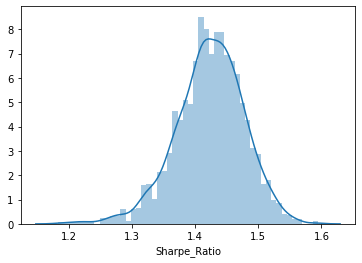

In [25]:
sns.distplot(df.Sharpe_Ratio, bins = 50)

In [30]:
df.Sharpe_Ratio.mean()

1.4232267435266082

In [31]:
df.Number_Stocks.mean()

19.893

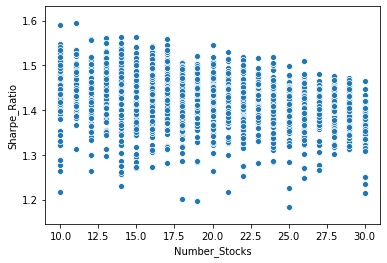

In [32]:
sns.scatterplot(x = 'Number_Stocks', y = 'Sharpe_Ratio', data = df)

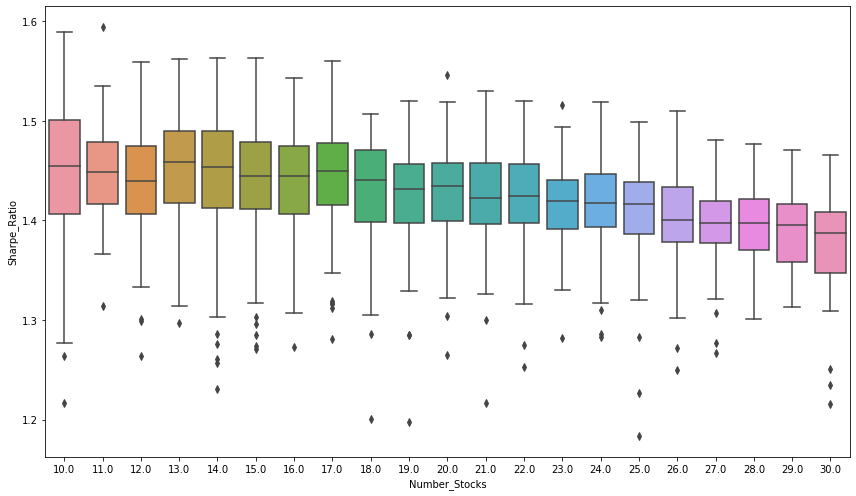

In [33]:
plt.figure(figsize=(12, 7))           
sns.boxplot(y='Sharpe_Ratio', x='Number_Stocks', 
                 data = df)
plt.tight_layout()

In [51]:
############### Monte Carlo Sim Showing Random Efficient Frontier (Kapitalmarkt-Linie) by assining random weights to our BIOTECH FOLIO ###############

# X,Y Plot: Exp_Vol vs Exp_Return

def monte_carlo(x, risk_free):
    
    ##########Parameters#######
    #Simulations
    sim = 50000
    sim_w = np.zeros((sim, len(x.columns)))
    sim_return = np.zeros(sim)
    sim_vol = np.zeros(sim)
    sim_sharpe = np.zeros(sim)
    
    #Manually adjust RiskFree rate
    #r = 0.00162999999999999970
    iteration = 0
    for i in range(sim):
        
        #initialize weights
        w = np.array(np.random.random(x.shape[1]))
        w = w / np.sum(w)#Normalization (sum of weights = 1)
        sim_w[i] = w
        
        #Expected Portfolio Return
        sim_return[i] = sum(x.mean()*w*252)
        
        #Expected Portfolio Vol
        sim_vol[i] = np.sqrt(np.dot(w.T, np.dot(x.cov()*252, w)))
        
        #Sharpe Ratio
        sim_sharpe[i] = (sim_return[i] - risk_free) / sim_vol[i]
        #print('Simulation: ', iteration)
        iteration += 1
    return sim_w, sim_return, sim_vol, sim_sharpe


bio_tick = d_biotech['Portfolio']
sim_w, sim_return, sim_vol, sim_sharpe = monte_carlo(x_train[bio_tick], rf)

max_w = sim_w[sim_sharpe.argmax()]
min_vol = sim_vol[sim_sharpe.argmax()]
max_ret = sim_return[sim_sharpe.argmax()]


Text(0, 0.5, 'Exp_Return')

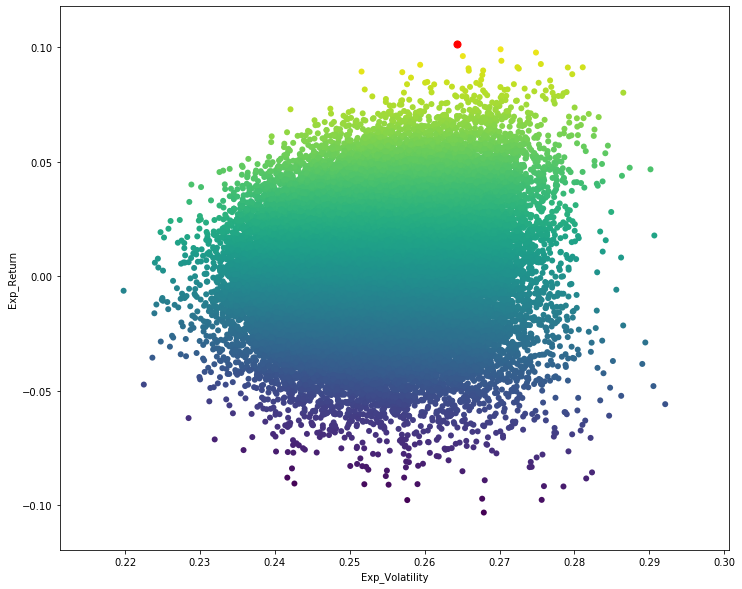

In [52]:
plt.figure(figsize=(12,10))
plt.scatter(sim_vol, sim_return, c = sim_sharpe, linewidths = .000001)
plt.scatter(min_vol, max_ret, c = 'red', s = 50)
#plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Exp_Volatility')
plt.ylabel('Exp_Return')    

In [53]:
max_w 

array([0.13842414, 0.18696598, 0.04253691, 0.00631911, 0.00626451,
       0.15621707, 0.00192546, 0.22810752, 0.23002856, 0.00321074])

In [54]:
min_vol

0.2643655729412702

In [55]:
max_ret

0.10153891412759794

In [59]:
(max_ret - rf)/min_vol

0.3342829898174006

In [57]:
d_biotech

{'Portfolio': ['GILD',
  'VRTX',
  'AMGN',
  'BIIB',
  'REGN',
  'ILMN',
  'ALXN',
  'SGEN',
  'INCY',
  'BMRN'],
 'Weights': array([0.01      , 0.22041889, 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.69958111, 0.01      ]),
 'E(r)_Vol_Sharpe': array([0.15444522, 0.30726141, 0.45980137])}

In [58]:
rf

0.01316600000000002

In [37]:
########## Test Phase ###########

#Large Cap Optimized Portfolio
#Biotech Optimized Portfolio


def portfolio_summary(folio_dictionary, market_data, risk_free):
        
    tick = np.array(folio_dictionary['Portfolio'])
    weight = np.array(folio_dictionary['Weights'])
    weighted_returns = np.array(market_data[tick]) * weight
    portfolio_return = np.sum(pd.DataFrame(weighted_returns).sum())#Return of Portfolio in Test Phase
    
    portfolio_daily_returns = np.zeros((market_data.shape[0], 1))
    for i in range(portfolio_daily_returns.shape[0]):
        portfolio_daily_returns[i] = np.sum(weighted_returns[i])
        
    daily_var = np.var(portfolio_daily_returns)
    daily_vol = daily_var**(1/2)
    annualized_vol = daily_vol * 250**(1/2)
    
    sharpe = (portfolio_return - risk_free) / annualized_vol
    
    return portfolio_return, annualized_vol, sharpe, portfolio_daily_returns 



In [38]:
bio_return, bio_annual_vol, bio_sharpe, bio_daily = portfolio_summary(d_biotech, x_test, rf)

In [39]:
large_cap_return, large_cap_annual_vol, large_cap_sharpe, large_cap_daily = portfolio_summary(l[sharpe.argmax()] , x_test, rf)

In [40]:
bio_return

0.2951686539812199

In [41]:
bio_annual_vol

0.3387669129545775

In [42]:
bio_sharpe

0.8324385977417792

In [43]:
large_cap_return

0.1489746778271709

In [44]:
large_cap_annual_vol

0.332517924809911

In [45]:
large_cap_sharpe

0.40842513348658727